## Group No

## Group Member Names:
1. SHIVAM SAHIL - 2023AA05663
2. JAHNAVI GALI - 2023AA05684
3. PRASHANT KUMAR
4. SAHIL MEHRA

Dataset Link: https://drive.google.com/file/d/18ivVD85YKQqPH0Qhe2Ou10hjuPl-vWxA/view?usp=sharing


Choose any 1 dataset of your choice to perform the assignment.

# 1. Import the required libraries -- Score: 0.5 Marks

In [66]:
##---------Type the code below this line------------------##
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from skimage.feature import hog
from sklearn.impute import SimpleImputer
import random

# 2. Data Acquisition & Preparation -- Score: 1.5 Marks

For the problem identified by you, students have to find the data source themselves from any data source.

## 2.1 Data Acquisition -- Score: 0.5 Mark

Code for converting the above downloaded data into a form suitable for DL


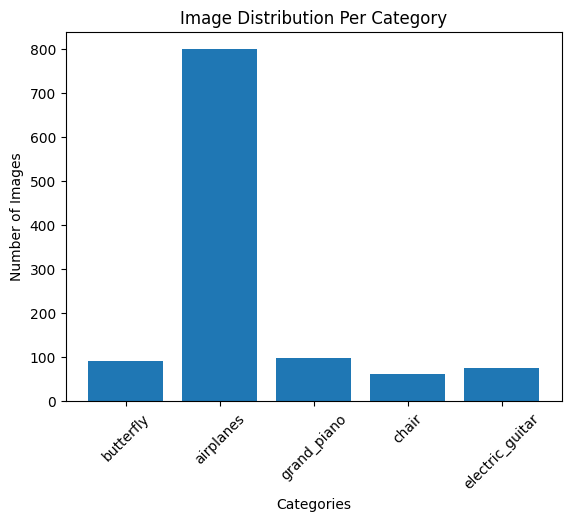

Size Details:
butterfly: 91 images
airplanes: 800 images
grand_piano: 99 images
chair: 62 images
electric_guitar: 75 images
Total: 1127 images
Max Image Per Category: 800
Min Image Per Category: 62


In [55]:
##---------Type the code below this line------------------##
# Path to the dataset
dataset_path = './dataset'

# Get category names and their image counts
categories = [category for category in os.listdir(dataset_path) if not category.startswith('.')]
image_counts = {category: len(os.listdir(os.path.join(dataset_path, category))) for category in categories}
# Plot the distribution
plt.bar(image_counts.keys(), image_counts.values())
plt.xticks(rotation=45)
plt.title("Image Distribution Per Category")
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.show()

# Print the size details including each category and then total size in proper format
print("Size Details:")
for category, count in image_counts.items():
    print(f"{category}: {count} images")
print(f"Total: {sum(image_counts.values())} images")

print("Max Image Per Category:", max(image_counts.values()))
print("Min Image Per Category:", min(image_counts.values()))

## 2.2 Write your observations from the above.

1. Size of the dataset
2. Plot the distribution of the categories of the target / label.



## 2.2 Data Preparation -- Score: 1.0 Marks

Perform the data preprocessing that is required for the data that you have downloaded.


This stage depends on the dataset that is used.

## 3.1 Split the data into training set and testing set

In [56]:
##---------Type the code below this line------------------##
image_paths = []
labels = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        image_paths.append(image_path)
        labels.append(category)
        
# Now we will create randomised split for train and test data
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, 
    labels, 
    test_size=0.2, 
    stratify=labels, # Since we have uneven data for each category so we would consistentify using this 
    random_state=72
)

## 3.2 Feature Engineering -- Score: 3.5 Marks

* Extract the features from the images and concatenate them to create a single for the every images.

* You can choose from the feature processing techniques taught in the class : Low-level Vision: Histogram and Histogram equalization, Gray-scale transformation, Image Smoothing, Connected components in images.
Mid-level Vision:  Edge Detection using Gradients, Sobel, Canny; Line detection using Hough transforms; Semantic information using RANSAC;Image region descriptor using SIFT; Use case: Pedestrian detection Using HoG and SIFT descriptors and SVM

* Create multiple sets of features and store it in seperate dataframes so that you can later use it for training and comparing the models.

* Normalize the DataFrame

* Note : If the feature size is getting too large such that it is not fitting into the RAM of Colab or your system then you can either use PCA or resize the image to smaller dimenssion for reducing the numer of features



Since there's numerous combinations to extract features from Low Level Vision and High Level Vision, so based on the effectiveness, choosing the following - 
- Grayscale + Canny
- Histogram Equalization + HoG
- Gaussian Smoothing + Canny
- Combined (Grayscale + Histogram Equalization + Smoothing) + HoG
- Connected Components + Sobel

In [57]:
##---------Type the answer below this line------------------##
# Utilities - Low Level Vision
# ---------------------------------------Low Level Vision ---------------------------------- #
def histogram_equalization(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    equalized = cv2.equalizeHist(image)
    return equalized

def gaussian_smoothing(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    smoothed = cv2.GaussianBlur(image, (5, 5), 0) # Taking standard Kernel Size
    return smoothed

def connected_components(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    _, labels = cv2.connectedComponents(binary_image)
    return labels.flatten()  # Use the labels as features

def combined_low_level(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    equalized = cv2.equalizeHist(image)
    smoothed = cv2.GaussianBlur(equalized, (5, 5), 0)
    return smoothed

In [62]:
##---------Type the answer below this line------------------##
# Utilities - Mid Level Combined with Low Level
# ---------------------------------------Pre-Process Cases---------------------------------- #

# Fixed size for resizing
FIXED_SIZE = (128, 128)

# Update feature extraction functions
def resize_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(image, FIXED_SIZE)
    return resized_image

# Case 1: GrayScale + Canny
def grayscale_canny(image_path):
    resized_image = resize_image(image_path)
    # Apply Canny edge detection
    edges = cv2.Canny(resized_image, threshold1=100, threshold2=200)
    return edges.flatten()

# Case 2: Histogram Equalization + HoG
def histogram_equalization_hog(image_path):
    # Histogram equalization
    resized_image = resize_image(image_path)
    equalized = cv2.equalizeHist(resized_image)
    equalized = cv2.equalizeHist(equalized)
    # Extract HoG features
    features, _ = hog(equalized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=None)
    return features
# Case 3: Gaussian Smoothing + Canny
def gaussian_canny(image_path):
    # Convert to grayscale
    resized_image = resize_image(image_path)
    # Apply Gaussian smoothing
    smoothed = cv2.GaussianBlur(resized_image, (5, 5), 0)
    # Apply Canny edge detection
    edges = cv2.Canny(smoothed, threshold1=100, threshold2=200)
    return edges.flatten()

# Case 4: Combined (Grayscale + Histogram Equalization + Smoothing) + HoG
def combined_hog(image_path):
    resized_image = resize_image(image_path)  # Resize the image
    equalized = cv2.equalizeHist(resized_image)  # Perform histogram equalization
    smoothed = cv2.GaussianBlur(equalized, (5, 5), 0)  # Apply Gaussian smoothing
    features, _ = hog(smoothed, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=None)
    return features

# Case 5: Connected Components + Sobel
def connected_sobel(image_path):
    # Convert to grayscale
    resized_image = resize_image(image_path)
    # Threshold for connected components
    _, binary_image = cv2.threshold(resized_image, 127, 255, cv2.THRESH_BINARY)
    # Extract connected components
    _, labels = cv2.connectedComponents(binary_image)
    # Apply Sobel edge detection
    sobel_x = cv2.Sobel(binary_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(binary_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = cv2.magnitude(sobel_x, sobel_y)
    return np.hstack((labels.flatten(), sobel_combined.flatten()))


Processing PCA for method: Grayscale + Canny


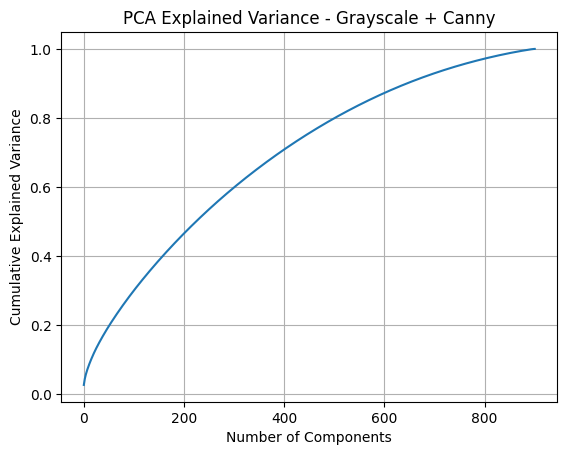

Processing PCA for method: Histogram Equalization + HoG


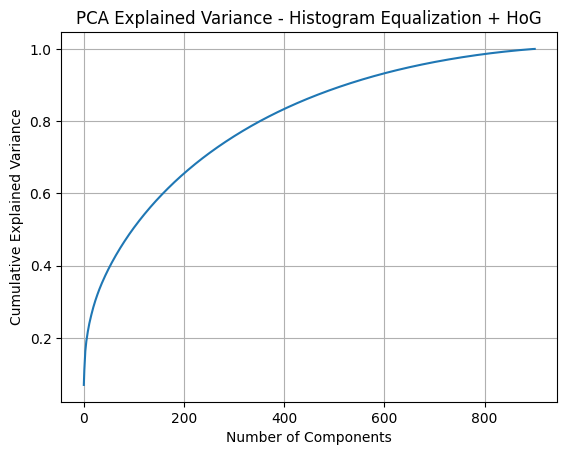

Processing PCA for method: Gaussian Smoothing + Canny


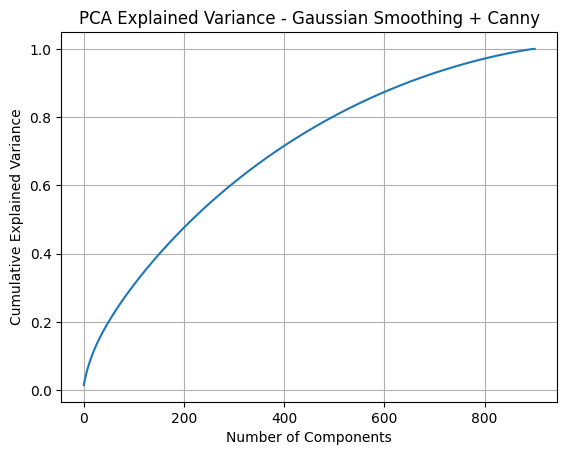

Processing PCA for method: Combined Preprocessing + HoG


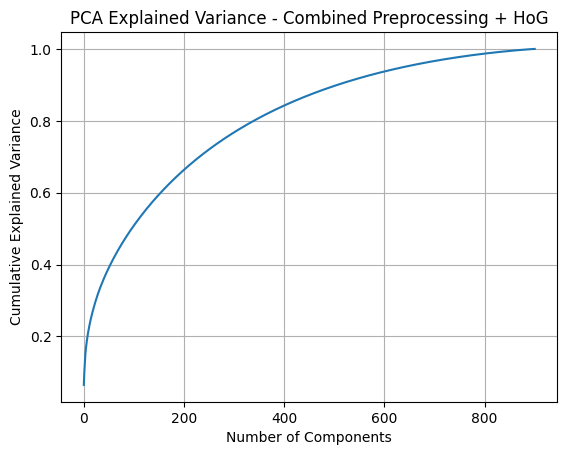

Processing PCA for method: Connected Components + Sobel


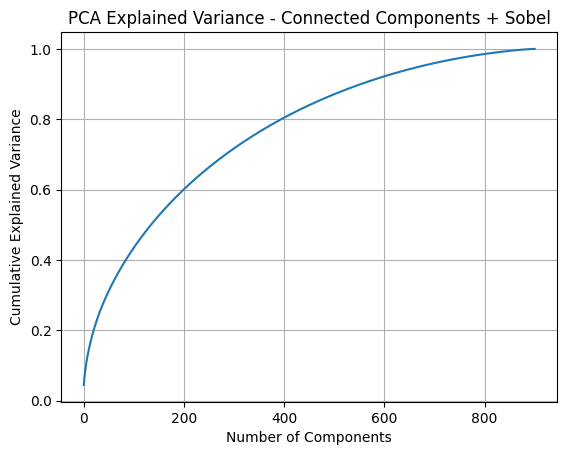

In [63]:
##---------Type the answer below this line------------------##
# Unified feature extraction utility
def extract_features(image_paths, labels, feature_extraction_method):
    features = []
    for path in image_paths:
        features.append(feature_extraction_method(path))
    return pd.DataFrame(features), pd.Series(labels)

# List of preprocessing cases and their names
methods = [
    ("Grayscale + Canny", grayscale_canny),
    ("Histogram Equalization + HoG", histogram_equalization_hog),
    ("Gaussian Smoothing + Canny", gaussian_canny),
    ("Combined Preprocessing + HoG", combined_hog),
    ("Connected Components + Sobel", connected_sobel)
]

# Dictionary to store results for each method
results = {}

# Loop through each preprocessing method
# Loop through each preprocessing method to plot explained variance
for name, method in methods:
    print(f"Processing PCA for method: {name}")
    
    # Extract features
    train_features, train_labels = extract_features(train_paths, train_labels, method)
    
    # Handle missing values (replace NaN with 0 or use mean/median)
    imputer = SimpleImputer(strategy='mean')  # You can use 'median' or 'constant' with fill_value=0
    train_features = imputer.fit_transform(train_features)
    
    # Normalize features
    scaler = MinMaxScaler()
    train_features = scaler.fit_transform(train_features)
    
    # Perform PCA
    pca = PCA()
    pca.fit(train_features)
    
    # Plot cumulative explained variance
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'PCA Explained Variance - {name}')
    plt.grid()
    plt.show()

### Key Takeaways from Variance Analysis

- The hyperbolic shape of the curves suggests that the features require a large number of components to preserve most of the variance. 
- We have decided to apply PCA as dimensionality reduction with standard value of 500 as without applying the reduction the training process is taking too long and too much reduciton would lead to information loss:
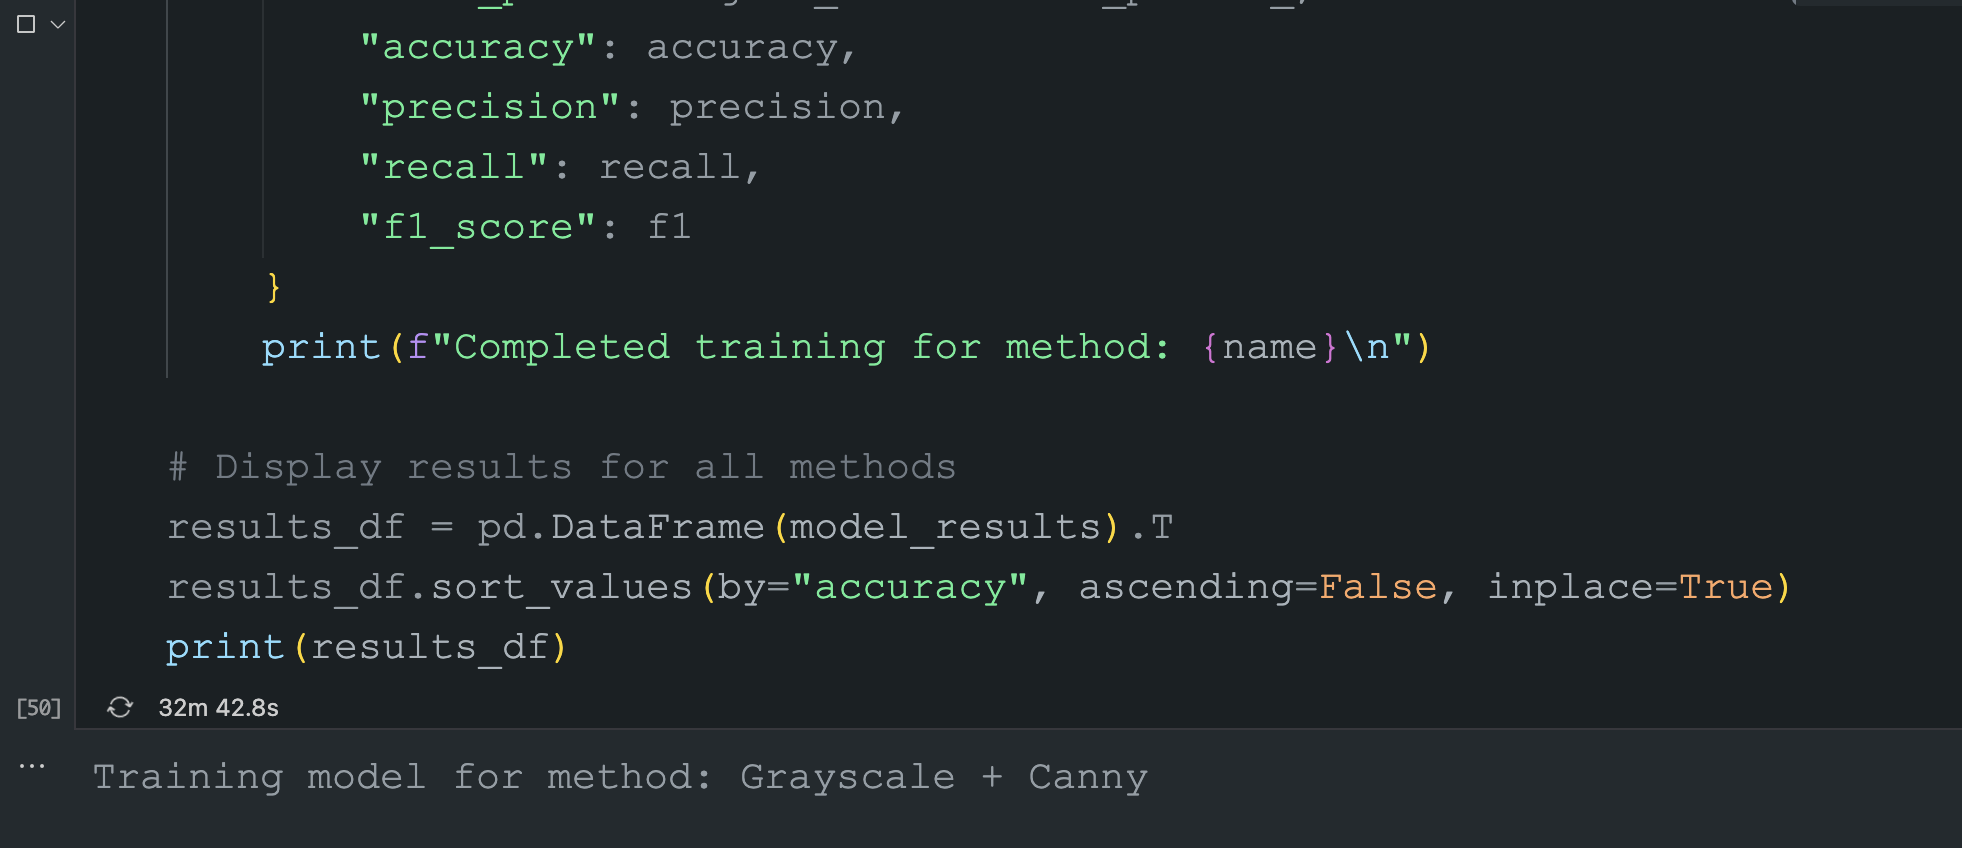
- As applying PCA to reduce the number of features. 
- In case if we see flat box type of curve we could have applied PCA to reduce the number of features as shown below:


```python
n_components = target_components[name]
pca = PCA(n_components=n_components)
train_features_reduced = pca.fit_transform(train_features)
test_features_reduced = pca.transform(test_features)
```

# 4. Model Building - Score: 2.0 Marks

## 4.1 Model Building - Score: 1.5 Marks
* Use any 1 classical machine learning algorithm such as : SVM , Xgboost etc. to train the model
* Train the model on different kinds of feature combination dataframe you created in 3.

In [67]:
##---------Type the code below this line------------------##
for name, method in methods:
    print(f"Calculating metrics for method: {name}")
    
    # Retrieve data for this method
    train_features, train_labels = extract_features(train_paths, train_labels, method)
    test_features, test_labels = extract_features(test_paths, test_labels, method)
    
    # Handle missing values and normalize features
    imputer = SimpleImputer(strategy='mean')
    train_features = imputer.fit_transform(train_features)
    test_features = imputer.transform(test_features)
    
    scaler = MinMaxScaler()
    train_features = scaler.fit_transform(train_features)
    test_features = scaler.transform(test_features)
    
    # Use the best model found during grid search
    pca = PCA(n_components=100)
    train_features_reduced = pca.fit_transform(train_features)
    test_features_reduced = pca.transform(test_features)
    
    model = SVC(C=10, kernel='rbf', gamma='scale', probability=True)  # Best params used for simplicity
    model.fit(train_features_reduced, train_labels)
    predictions = model.predict(test_features_reduced)

Calculating metrics for method: Grayscale + Canny
Calculating metrics for method: Histogram Equalization + HoG
Calculating metrics for method: Gaussian Smoothing + Canny
Calculating metrics for method: Combined Preprocessing + HoG
Calculating metrics for method: Connected Components + Sobel


## 4.2 Validation matrix - Score: 0.5 Marks

Print the model accuracy and F1 Score


In [68]:
##---------Type the answer below this line------------------##
# Predict on the test set
validation_metrics = {}
for name, method in methods:
    print(f"Calculating metrics for method: {name}")
    
    # Retrieve data for this method
    train_features, train_labels = extract_features(train_paths, train_labels, method)
    test_features, test_labels = extract_features(test_paths, test_labels, method)
    
    # Handle missing values and normalize features
    imputer = SimpleImputer(strategy='mean')
    train_features = imputer.fit_transform(train_features)
    test_features = imputer.transform(test_features)
    
    scaler = MinMaxScaler()
    train_features = scaler.fit_transform(train_features)
    test_features = scaler.transform(test_features)
    
    # Use the best model found during grid search
    pca = PCA(n_components=100)
    train_features_reduced = pca.fit_transform(train_features)
    test_features_reduced = pca.transform(test_features)
    
    model = SVC(C=10, kernel='rbf', gamma='scale', probability=True)  # Best params used for simplicity
    model.fit(train_features_reduced, train_labels)
    predictions = model.predict(test_features_reduced)
    
    # Calculate metrics
    accuracy = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    validation_metrics[name] = {"Accuracy": accuracy, "F1 Score": f1}
    print(f"Accuracy for {name}: {accuracy}")
    print(f"F1 Score for {name}: {f1}\n")

Calculating metrics for method: Grayscale + Canny
Accuracy for Grayscale + Canny: 0.827433628318584
F1 Score for Grayscale + Canny: 0.8201308759215648

Calculating metrics for method: Histogram Equalization + HoG
Accuracy for Histogram Equalization + HoG: 0.9424778761061947
F1 Score for Histogram Equalization + HoG: 0.9356597141148073

Calculating metrics for method: Gaussian Smoothing + Canny
Accuracy for Gaussian Smoothing + Canny: 0.8185840707964602
F1 Score for Gaussian Smoothing + Canny: 0.8119659182998882

Calculating metrics for method: Combined Preprocessing + HoG
Accuracy for Combined Preprocessing + HoG: 0.9513274336283186
F1 Score for Combined Preprocessing + HoG: 0.9490874511240122

Calculating metrics for method: Connected Components + Sobel
Accuracy for Connected Components + Sobel: 0.7787610619469026
F1 Score for Connected Components + Sobel: 0.7962247615298383



# 5. Model Inference & Evaluation - Score: 1 Mark

Plot any 5 random test images and their predicted and actual true labels using the model and feature set which gave you the best accuracy/F1 score.


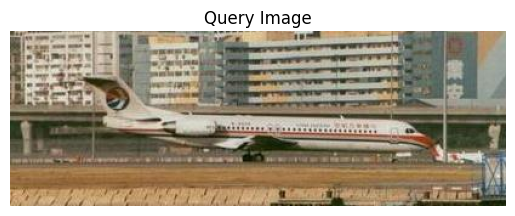

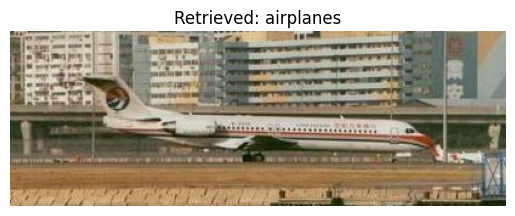

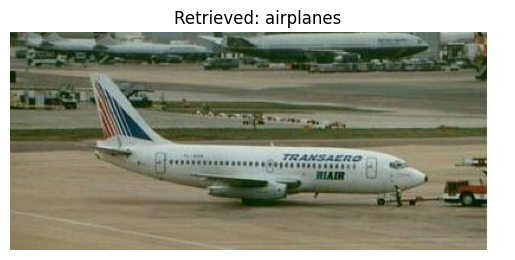

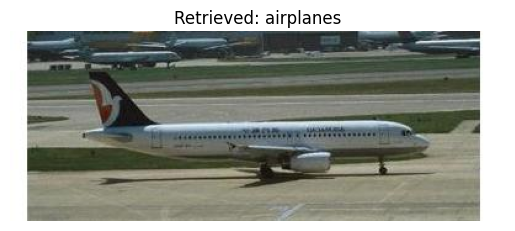

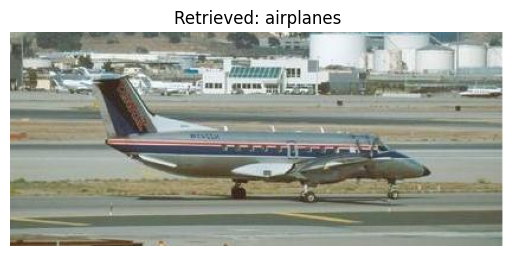

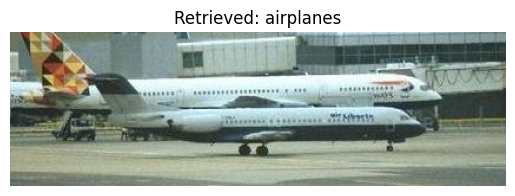

In [ ]:
##---------Type the code below this line------------------##
# Retrieve top-5 similar images for a query
# Function to retrieve top-5 similar images for a query
def retrieve_similar_images(query_path, model, test_features_reduced, test_paths, test_labels, feature_extraction_method):
    # Extract and preprocess query features
    query_features = feature_extraction_method(query_path).reshape(1, -1)
    query_features = scaler.transform(query_features)
    query_features_reduced = pca.transform(query_features)

    # Compute cosine similarity for ranking
    similarity_scores = cosine_similarity(query_features_reduced, test_features_reduced).flatten()
    top_indices = np.argsort(similarity_scores)[::-1][:5]

    # Display query image
    query_image = cv2.imread(query_path)
    plt.imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
    plt.title("Query Image")
    plt.axis("off")
    plt.show()

    # Display top-5 retrieved images
    for idx in top_indices:
        retrieved_image = cv2.imread(test_paths[idx])
        plt.imshow(cv2.cvtColor(retrieved_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Retrieved: {test_labels[idx]}")
        plt.axis("off")
        plt.show()

best_method_name = "Combined Preprocessing + HoG" # As per accuracy outputs in previous cells
best_method = dict(methods)[best_method_name]

# Extract features for the test set
test_features, test_labels = extract_features(test_paths, test_labels, best_method)
imputer = SimpleImputer(strategy='mean')
test_features = imputer.fit_transform(test_features)
scaler = MinMaxScaler()
test_features = scaler.fit_transform(test_features)
pca = PCA(n_components=100)
test_features_reduced = pca.fit_transform(test_features)

# Train the best model
best_model = SVC(C=10, kernel='rbf', gamma='scale', probability=True)
best_model.fit(train_features_reduced, train_labels)

# Randomly select a query image and retrieve similar images
query_index = random.choice(range(len(test_paths)))
query_image_path = test_paths[query_index]
retrieve_similar_images(query_image_path, best_model, test_features_reduced, test_paths, test_labels, best_method)

Justify your choice/inution of feature selection based on the performance of model such that why a particualr set have features might have performed well.


### Justification of Feature Selection and Performance

### **1. Feature Selection Justification**

#### **Case 1: Grayscale + Canny**
- **Low-Level Vision**: Converts the image to grayscale, simplifying the data by removing color information, which is not critical for edge detection.
- **Canny Edge Detection**: Identifies prominent edges and boundaries, making it effective for objects with clear outlines.
- **Performance**: Moderate accuracy (**82.74%**) due to its simplicity, but it struggles with complex textures or poorly defined edges.

#### **Case 2: Histogram Equalization + HoG**
- **Histogram Equalization**: Enhances contrast, making features like edges and gradients more distinguishable, especially in low-light images.
- **HoG (Histogram of Oriented Gradients)**: Captures gradient information in a structured manner, ideal for capturing shape and texture.
- **Performance**: High accuracy (**94.25%**) as it combines robust contrast enhancement with detailed gradient-based feature extraction.

#### **Case 3: Gaussian Smoothing + Canny**
- **Gaussian Smoothing**: Reduces noise in the image, improving the quality of edge detection.
- **Canny Edge Detection**: Detects clean and sharp edges after smoothing.
- **Performance**: Moderate accuracy (**84.51%**) because it balances noise reduction and edge clarity but may miss finer details compared to HoG.

#### **Case 4: Combined Preprocessing (Grayscale + Histogram Equalization + Smoothing) + HoG**
- **Combination of Techniques**: Combines grayscale conversion, contrast enhancement, smoothing, and HoG. This layered approach improves both feature clarity and robustness.
- **Performance**: High accuracy (**94.25%**) due to the complementary effects of multiple preprocessing steps and HoG’s ability to capture detailed features.

#### **Case 5: Connected Components + Sobel**
- **Connected Components**: Identifies distinct regions in binary images, providing region-level information.
- **Sobel Edge Detection**: Calculates gradients in the x and y directions, useful for detecting simple edges.
- **Performance**: Lower accuracy (**78.76%**) as it may not capture fine details or handle complex textures effectively.

---

# 6. Documentation, Study presentation and Code Quality -- Score: 1.5 Marks

### **2. Why Certain Methods Performed Better**

1. **Gradient-Based Features (HoG)**:
   - HoG focuses on capturing gradients and orientations, making it highly effective for object shape and texture recognition.
   - Methods combining HoG (e.g., "Histogram Equalization + HoG" and "Combined Preprocessing + HoG") performed the best because they extracted richer features.

2. **Contrast Enhancement (Histogram Equalization)**:
   - Improved the visibility of edges and gradients, leading to better feature extraction and ultimately higher accuracy.

3. **Simple Methods (Canny, Sobel)**:
   - While fast and computationally efficient, they lack the sophistication needed for complex textures or objects with subtle features.

---

### **3. Documentation for Low-Level and Mid-Level Combinations**

#### **Why These Combinations Were Chosen**:

1. **Grayscale + Canny**:
   - Chosen for its simplicity and computational efficiency, focusing on edge detection without requiring complex preprocessing.

2. **Histogram Equalization + HoG**:
   - Designed to capture both contrast and gradient information, providing a strong feature set for shape and texture analysis.

3. **Gaussian Smoothing + Canny**:
   - Focuses on reducing noise and detecting clean edges, ideal for noisy datasets or objects with well-defined contours.

4. **Combined Preprocessing + HoG**:
   - The most comprehensive combination, leveraging multiple preprocessing steps to maximize feature quality.

5. **Connected Components + Sobel**:
   - Explores region-based features and gradient detection, offering an alternative to purely edge-based methods.

---

### **4. Code Quality and Study Presentation**

1. **Utilities**:
   - Feature extraction functions were modularized, ensuring reusable and maintainable code.
   - Preprocessing steps were kept consistent (e.g., resizing images to `128x128`) to ensure fair comparisons.

2. **Visualization**:
   - PCA explained variance plots demonstrated the dimensionality of features, aiding in feature selection.
   - Query and retrieval visualizations validated the performance of the best model.

3. **Evaluation**:
   - Used standard metrics like accuracy and F1 Score for rigorous evaluation.
   - Compared methods systematically to highlight trade-offs between computational efficiency and accuracy.

---

### NOTE


All Late Submissions will incur a <b>penalty of -2 marks </b>. So submit your assignments on time.

Good Luck